In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        B1 = branch_output[:,:100]
        B2 = branch_output[:,100:]
        
        T1 = trunk_output[:,:100]
        T2 = trunk_output[:,100:]
        s1 = torch.sum(B1 * T1,axis=1).view(-1,1)
        s2 = torch.sum(B2 * T2,axis=1).view(-1,1)
        return s1, s2

cuda


In [3]:
class PINN_Vibratec:
    def __init__(self, model):
        self.L = 200
        self.H = 50
        self.model = model
        self.Losses = []
        self.file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_ElasticMechanics\\pDeepONet_Elastic_2D.pkl'
        self.train_set, self.test_set = self.load_Train_set()
        self.train_data = pd.concat(self.train_set.values(), ignore_index=True)
        self.test_data = pd.concat(self.test_set.values(), ignore_index=True)
        self.E = 1000
        self.rou = 0.3
        self.lamd = self.E * self.rou / (1 + self.rou) / (1 - 2 * self.rou)
        self.mu = self.E / 2 / (1 + self.rou)
        
    def load_model(self):
        self.model.load_state_dict(torch.load(self.file_name, weights_only=True))
        
    def u_function(self, B_data, T_data):
        u, v = self.model(B_data, T_data)
        return u, v
        
    def stress_function(self, B_data, T_data):
        x = B_data[:,0:1]
        y = B_data[:,1:2]
        u, v = self.model(torch.hstack((x,y)), T_data)
        
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, torch.ones_like(v), retain_graph=True, create_graph=True)[0]

        e_xx = u_x
        e_yy = v_y
        e_xy = (u_y + v_x)/2.0
        e_kk = e_xx + e_yy

        sigma_xx = self.lamd*e_kk + 2*self.mu*e_xx
        sigma_yy = self.lamd*e_kk + 2*self.mu*e_yy
        sigma_xy = 2*self.mu*e_xy

        s11_1 = torch.autograd.grad(sigma_xx, x, torch.ones_like(sigma_xx), retain_graph=True, create_graph=True)[0]
        s12_2 = torch.autograd.grad(sigma_xy, y, torch.ones_like(sigma_xy), retain_graph=True, create_graph=True)[0]
        s22_2 = torch.autograd.grad(sigma_yy, y, torch.ones_like(sigma_yy), retain_graph=True, create_graph=True)[0]
        s12_1 = torch.autograd.grad(sigma_xy, x, torch.ones_like(sigma_xy), retain_graph=True, create_graph=True)[0]

        sigma_1 = s11_1 + s12_2   # 法向应力散度
        sigma_2 = s12_1 + s22_2   # 切向应力散度
    
        return sigma_xx, sigma_yy, sigma_xy, sigma_1, sigma_2
        
    def get_data_Loss(self, B_data, T_data, u_data):
        bc_data = np.ones(B_data.shape)
        bc_data[:,0:1] = bc_data[:,0:1]*(-self.L)
        bc_data[:,1:2] = bc_data[:,1:2]*np.random.random([B_data.shape[0],1])*self.H
        bc_data = torch.tensor(bc_data, dtype=torch.float32, requires_grad=True).to(device)

        u_pre, v_pre = self.u_function(B_data, T_data)
        u_bc, v_bc = self.u_function(bc_data, T_data)
        u_ex = u_data[:,0:1]
        v_ex = u_data[:,1:2]
        loss = torch.mean(torch.square(u_pre - u_ex)) + torch.mean(torch.square(v_pre - v_ex)) + \
        torch.mean(torch.square(u_bc)) + torch.mean(torch.square(v_bc))
        return loss

    def get_pde_Loss(self, B_data, T_data, u_data):
        sigma_xx, sigma_yy, sigma_xy, sigma_1, sigma_2 = self.stress_function(B_data, T_data)
        
        loss = torch.mean(torch.square(sigma_1)) + torch.mean(torch.square(sigma_2))
        return loss
        
    def test_Loss(self):
        B_data = self.test_data[['x','y']]
        T_data = self.test_data[['T']]
        u_data = self.test_data[['u','v']]
        B_data = torch.tensor(np.array(B_data), dtype=torch.float32, requires_grad=False).to(device)
        T_data = torch.tensor(np.array(T_data), dtype=torch.float32, requires_grad=False).to(device)
        u_data = torch.tensor(np.array(u_data), dtype=torch.float32, requires_grad=False).to(device)
        
        u_pre, v_pre = self.u_function(B_data, T_data)
        u_ex = u_data[:,0:1]
        v_ex = u_data[:,1:2]
        loss = torch.mean(torch.square(u_pre - u_ex)) + torch.mean(torch.square(v_pre - v_ex))

        return loss
        
    def train(self, epochs, learning_rate, step_size=400, gamma=0.5):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        for epoch in range(epochs):
            if epoch % 100 == 0:
                B_data, T_data, u_data = self.get_Train_data(10000)
            self.optimizer.zero_grad()
            data_loss = self.get_data_Loss(B_data, T_data, u_data)
            pde_loss = self.get_pde_Loss(B_data, T_data, u_data)
            loss = data_loss + pde_loss
            loss.backward()
            self.Losses.append([loss.item(),data_loss.item(),pde_loss.item()])
            self.optimizer.step()
            self.scheduler.step()
            if epoch % 100 == 0:
                print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item():.8f}] [data_loss: {data_loss.item():.8f}] [pde_loss: {pde_loss.item():.8f}]")
                torch.save(self.model.state_dict(), self.file_name)
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}] [data_loss: {data_loss.item()}] [pde_loss: {pde_loss.item()}]")
        torch.save(self.model.state_dict(), self.file_name)
        print("Current learning rate:", self.optimizer.param_groups[0]['lr'])
        return loss

    def plot_loss(self):
        plt.title('log(loss)')
        temp = np.array(self.Losses)
        for i in range(temp.shape[1]):
            plt.plot(np.log(temp[:, i]).flatten(), label=f'Loss {i+1}')
        plt.legend()
        plt.show()
        
    def predict(self, B_data, T_data):
        u_pre, v_pre = self.u_function(B_data, T_data)
        u_pre = u_pre.cpu().detach().numpy()
        v_pre = v_pre.cpu().detach().numpy()
        return u_pre, v_pre

    def u_Exact(self, u_data):
        u_ex = u_data[:,0:1].cpu().detach().numpy()
        v_ex = u_data[:,1:2].cpu().detach().numpy()
        return u_ex, v_ex
        
    def plot_result(self, Numble=0):
        loss = self.test_Loss()
        print(f'Total Loss = {loss}')
        B_data, T_data, u_data = self.get_Test_data(Numble)

        print(f'Force = {T_data[0][0].cpu().detach().numpy()}')
        
        u_pre, v_pre = self.predict(B_data, T_data)
        u_ex, v_ex = self.u_Exact(u_data)
        x_np = B_data[:,0:1].cpu().detach().numpy()
        y_np = B_data[:,1:2].cpu().detach().numpy()

        X_pre = (x_np + u_pre)
        Y_pre = (y_np + v_pre)

        X_ex = (x_np + u_ex)
        Y_ex = (y_np + v_ex)
        
        u_err = np.abs(u_ex - u_pre)
        v_err = np.abs(v_ex - v_pre)
        
        print(f'RMSE U = {np.linalg.norm(u_err)/np.linalg.norm(u_ex)} RMSE V = {np.linalg.norm(v_err)/np.linalg.norm(v_ex)}')
        
        plt.figure(figsize=(18,9))
        plt.subplot(2,3,1)
        plt.scatter(X_pre, Y_pre, c = u_pre, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U Pre')
        plt.tight_layout()
        
        plt.subplot(2,3,2)
        plt.scatter(X_ex, Y_ex, c = u_ex, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U Exact')
        plt.tight_layout()
        
        plt.subplot(2,3,3)
        plt.scatter(X_pre, Y_pre, c = u_err, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U Error')
        plt.tight_layout()
        
        plt.subplot(2,3,4)
        plt.scatter(X_pre, Y_pre, c = v_pre, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('V Pre')
        plt.tight_layout()
        
        plt.subplot(2,3,5)
        plt.scatter(X_ex, Y_ex, c = v_ex, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('V Exact')
        plt.tight_layout()
        
        plt.subplot(2,3,6)
        plt.scatter(X_pre, Y_pre, c = v_err, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('V Error')
        plt.tight_layout()
        
        plt.show()

    def get_Train_data(self, Nu):
        sampled_data = self.train_data.sample(n=Nu)
        B_data = sampled_data[['x','y']]
        T_data = sampled_data[['T']]
        u_data = sampled_data[['u','v']]
        B_data = torch.tensor(np.array(B_data), dtype=torch.float32, requires_grad=True).to(device)
        T_data = torch.tensor(np.array(T_data), dtype=torch.float32, requires_grad=True).to(device)
        u_data = torch.tensor(np.array(u_data), dtype=torch.float32, requires_grad=True).to(device)
        return B_data, T_data, u_data
        
    def get_Test_data(self, Numble=0):
        sampled_data = self.test_set[list(self.test_set.keys())[Numble]]
        B_data = sampled_data[['x','y']]
        T_data = sampled_data[['T']]
        u_data = sampled_data[['u','v']]
        B_data = torch.tensor(np.array(B_data), dtype=torch.float32, requires_grad=True).to(device)
        T_data = torch.tensor(np.array(T_data), dtype=torch.float32, requires_grad=True).to(device)
        u_data = torch.tensor(np.array(u_data), dtype=torch.float32, requires_grad=True).to(device)
        return B_data, T_data, u_data
        
    def load_Train_set(self):
        data_set = {}
        folder_path = 'E:\Matlab\Matlab_File\Deep\DeepONet_Data'
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data_set[file_name[:7]] = pd.read_csv(file)
                    data_set[file_name[:7]]['T'] = np.array(file_name[:7],dtype=np.float64)
                    pass
        keys = list(data_set.keys())
        np.random.shuffle(keys)
        train_keys = keys[:80]
        test_keys = keys[80:]
        train_set = {key: data_set[key] for key in train_keys}
        test_set = {key: data_set[key] for key in test_keys}
        return train_set, test_set

In [4]:
model = DeepONet(2, 1, 100, 200).to(device)
PINNs_model = PINN_Vibratec(model)
loss = PINNs_model.train(epochs = 100000, learning_rate = 1e-3, step_size=2000, gamma=0.9)

[Epoch 1/100000] [loss: 1581.18078613] [data_loss: 1572.27160645] [pde_loss: 8.90914536]
[Epoch 101/100000] [loss: 1616.09143066] [data_loss: 124.63354492] [pde_loss: 1491.45788574]
[Epoch 201/100000] [loss: 227.59225464] [data_loss: 79.44548798] [pde_loss: 148.14675903]
[Epoch 301/100000] [loss: 137.00381470] [data_loss: 36.11072922] [pde_loss: 100.89308929]
[Epoch 401/100000] [loss: 56.97193909] [data_loss: 28.55883026] [pde_loss: 28.41311073]
[Epoch 501/100000] [loss: 106.22751617] [data_loss: 15.93195629] [pde_loss: 90.29556274]
[Epoch 601/100000] [loss: 33.51795959] [data_loss: 19.56858826] [pde_loss: 13.94937325]
[Epoch 701/100000] [loss: 25.14443779] [data_loss: 12.42754745] [pde_loss: 12.71689034]
[Epoch 801/100000] [loss: 52.31014252] [data_loss: 13.12333107] [pde_loss: 39.18681335]
[Epoch 901/100000] [loss: 17.02161598] [data_loss: 6.09723091] [pde_loss: 10.92438507]
[Epoch 1001/100000] [loss: 14.24529076] [data_loss: 5.76056623] [pde_loss: 8.48472500]
[Epoch 1101/100000] [lo

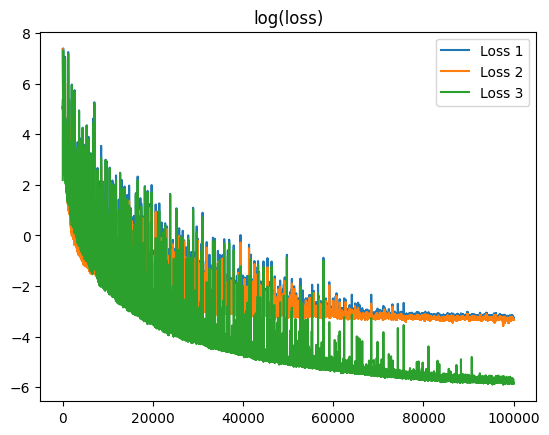

Total Loss = 0.02927175536751747
Force = 3.5353500843048096
RMSE U = 0.004725735634565353 RMSE V = 0.004380140919238329


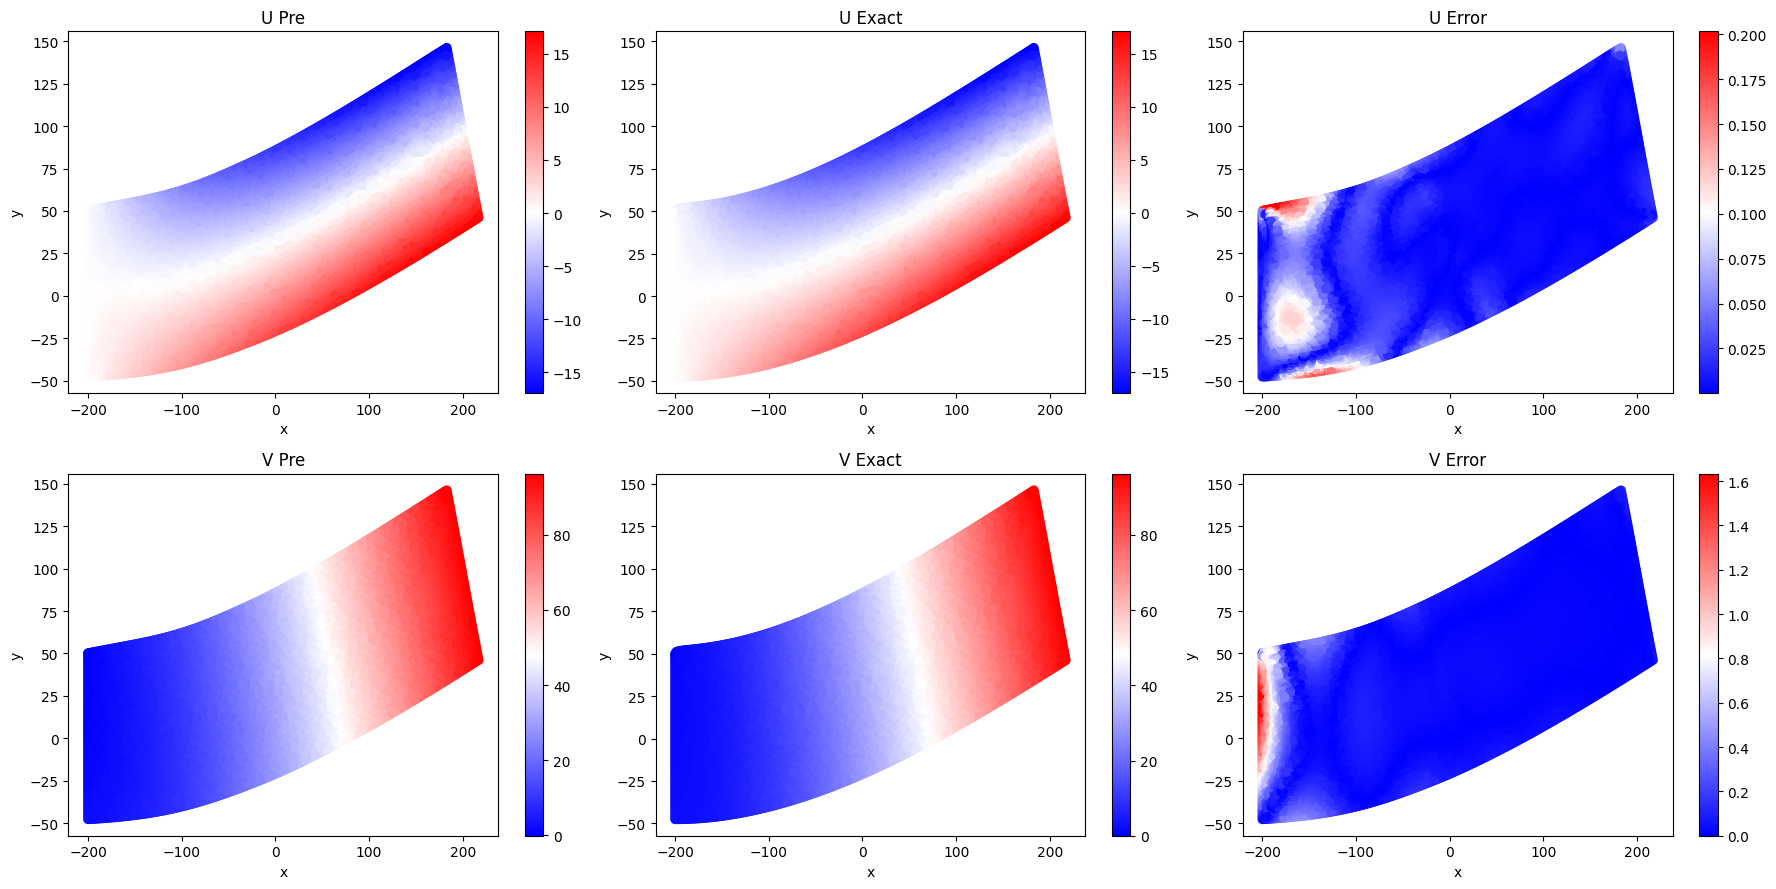

Total Loss = 0.02927175536751747
Force = 1.9696999788284302
RMSE U = 0.0047011724673211575 RMSE V = 0.004384706262499094


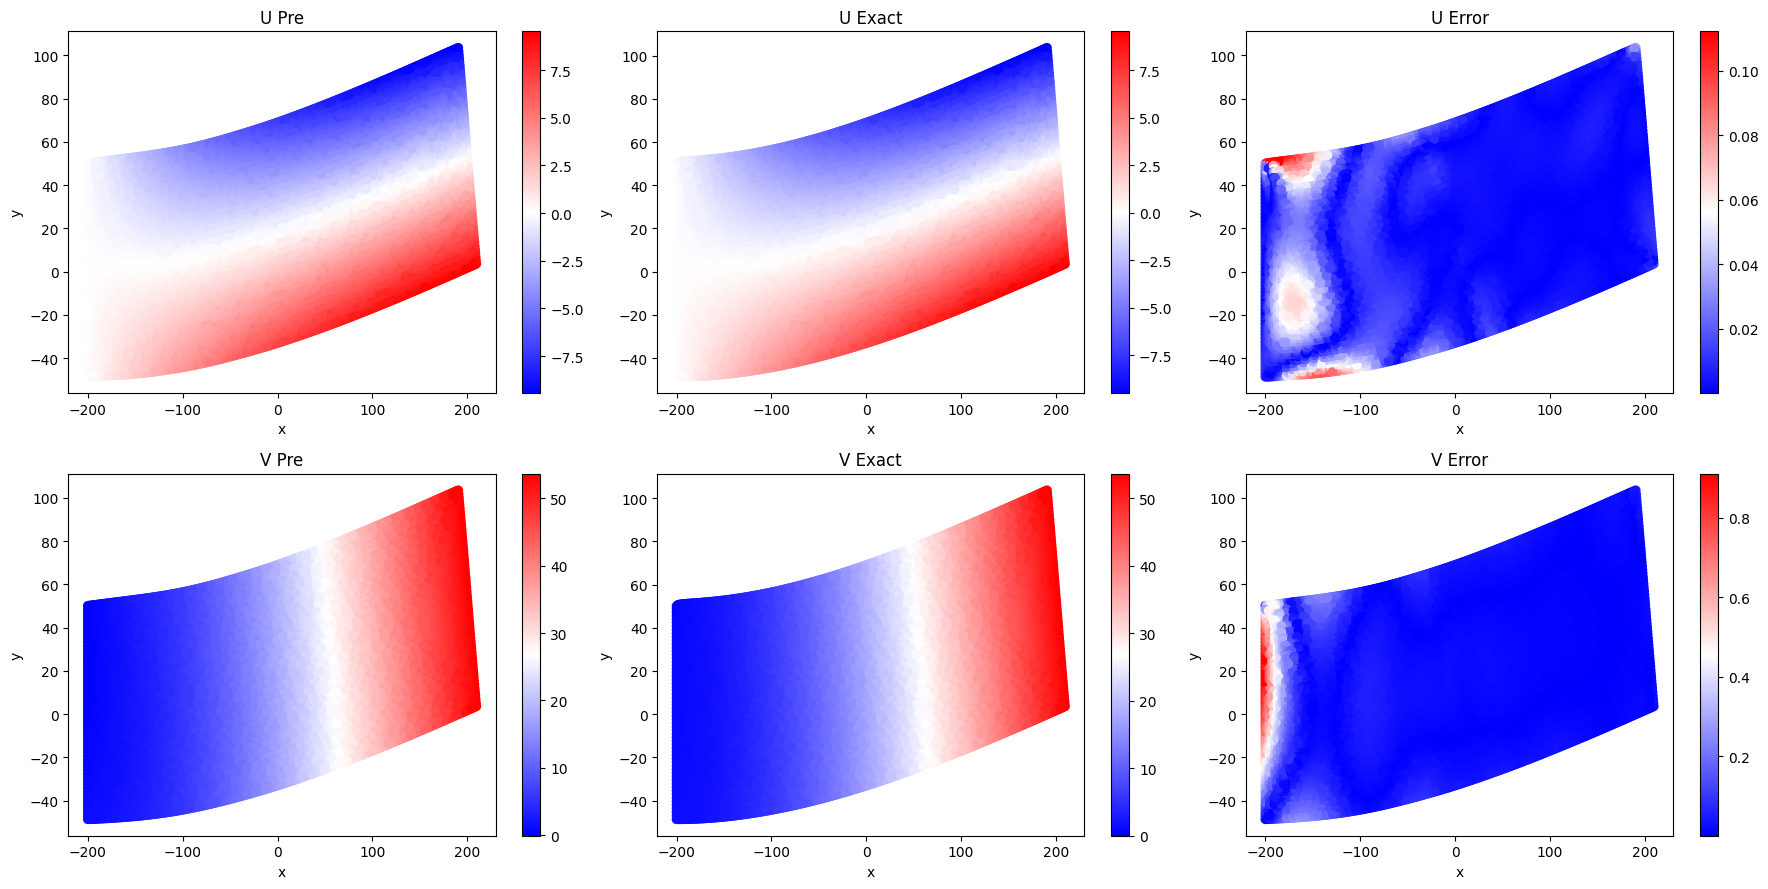

Total Loss = 0.02927175536751747
Force = 3.6868700981140137
RMSE U = 0.00471897516399622 RMSE V = 0.004379271529614925


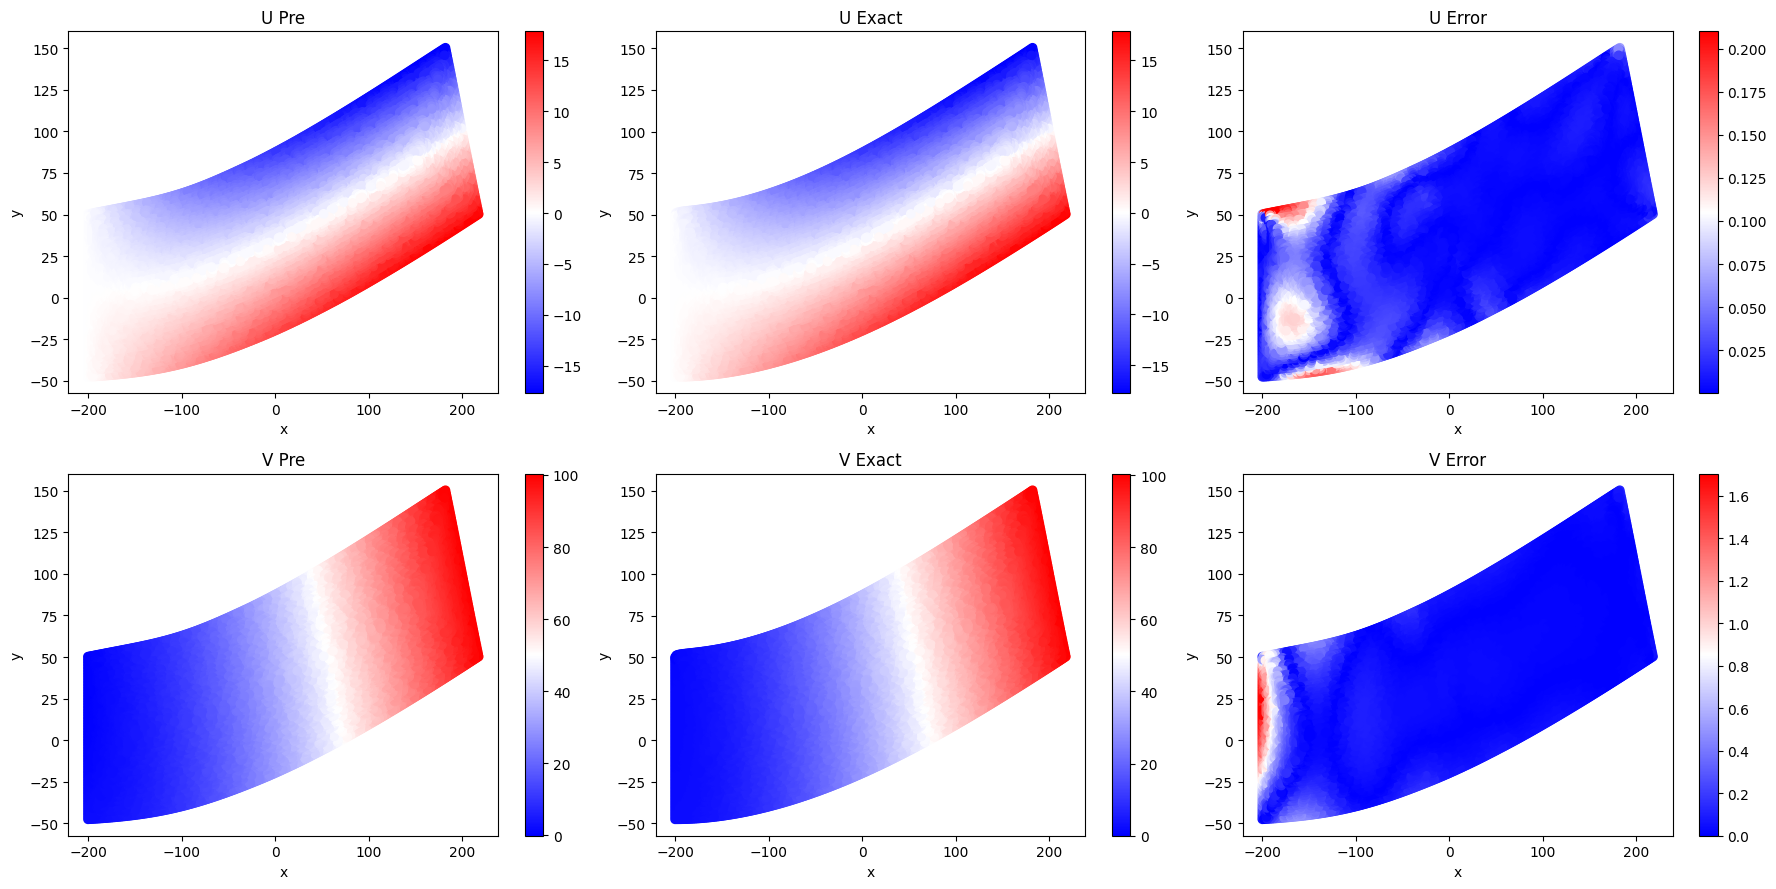

Total Loss = 0.02927175536751747
Force = 1.6666699647903442
RMSE U = 0.004720220807939768 RMSE V = 0.0043851821683347225


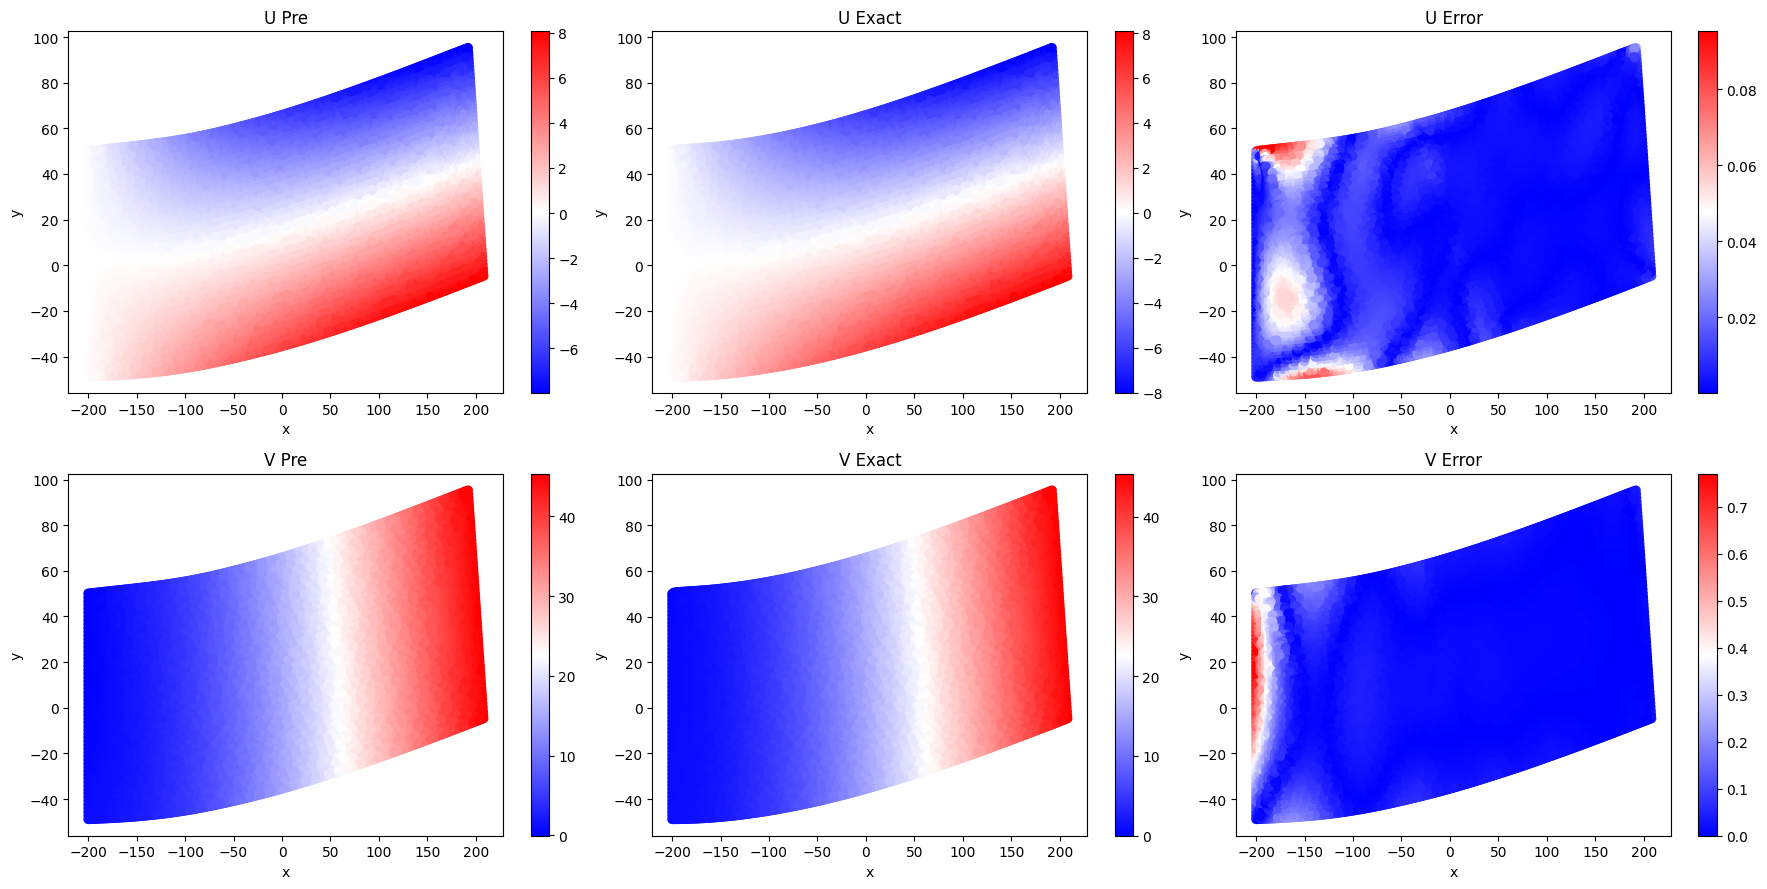

Total Loss = 0.02927175536751747
Force = 3.585860013961792
RMSE U = 0.00472314702346921 RMSE V = 0.0043798694387078285


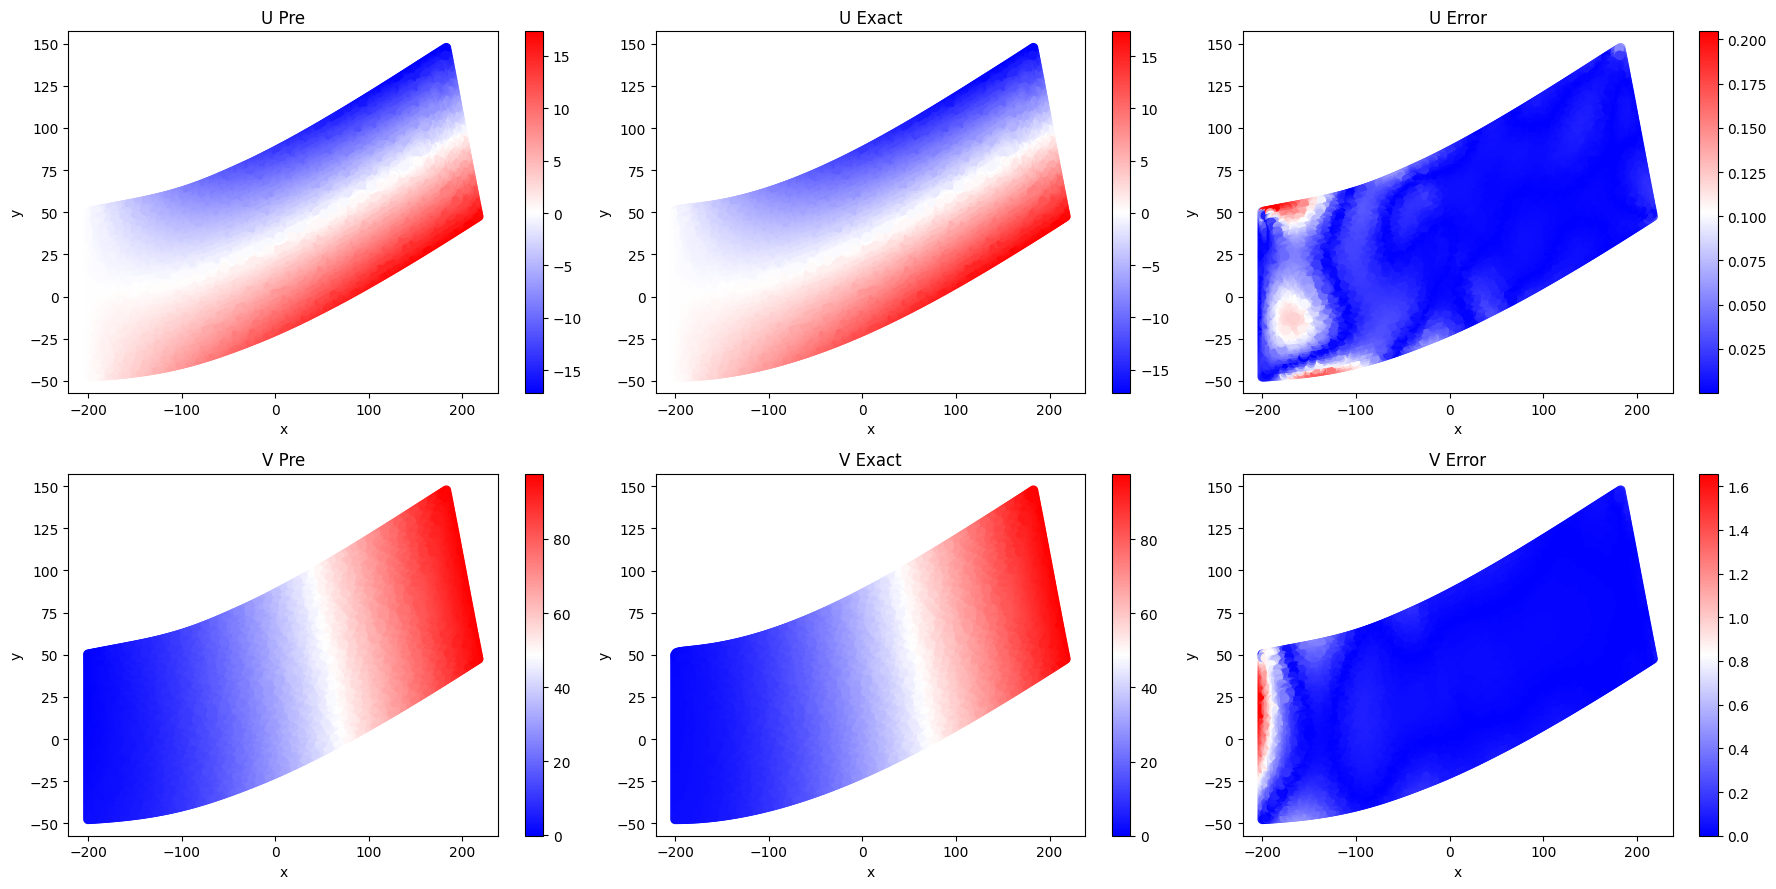

Total Loss = 0.02927175536751747
Force = 3.8383800983428955
RMSE U = 0.004717761185020208 RMSE V = 0.004378721583634615


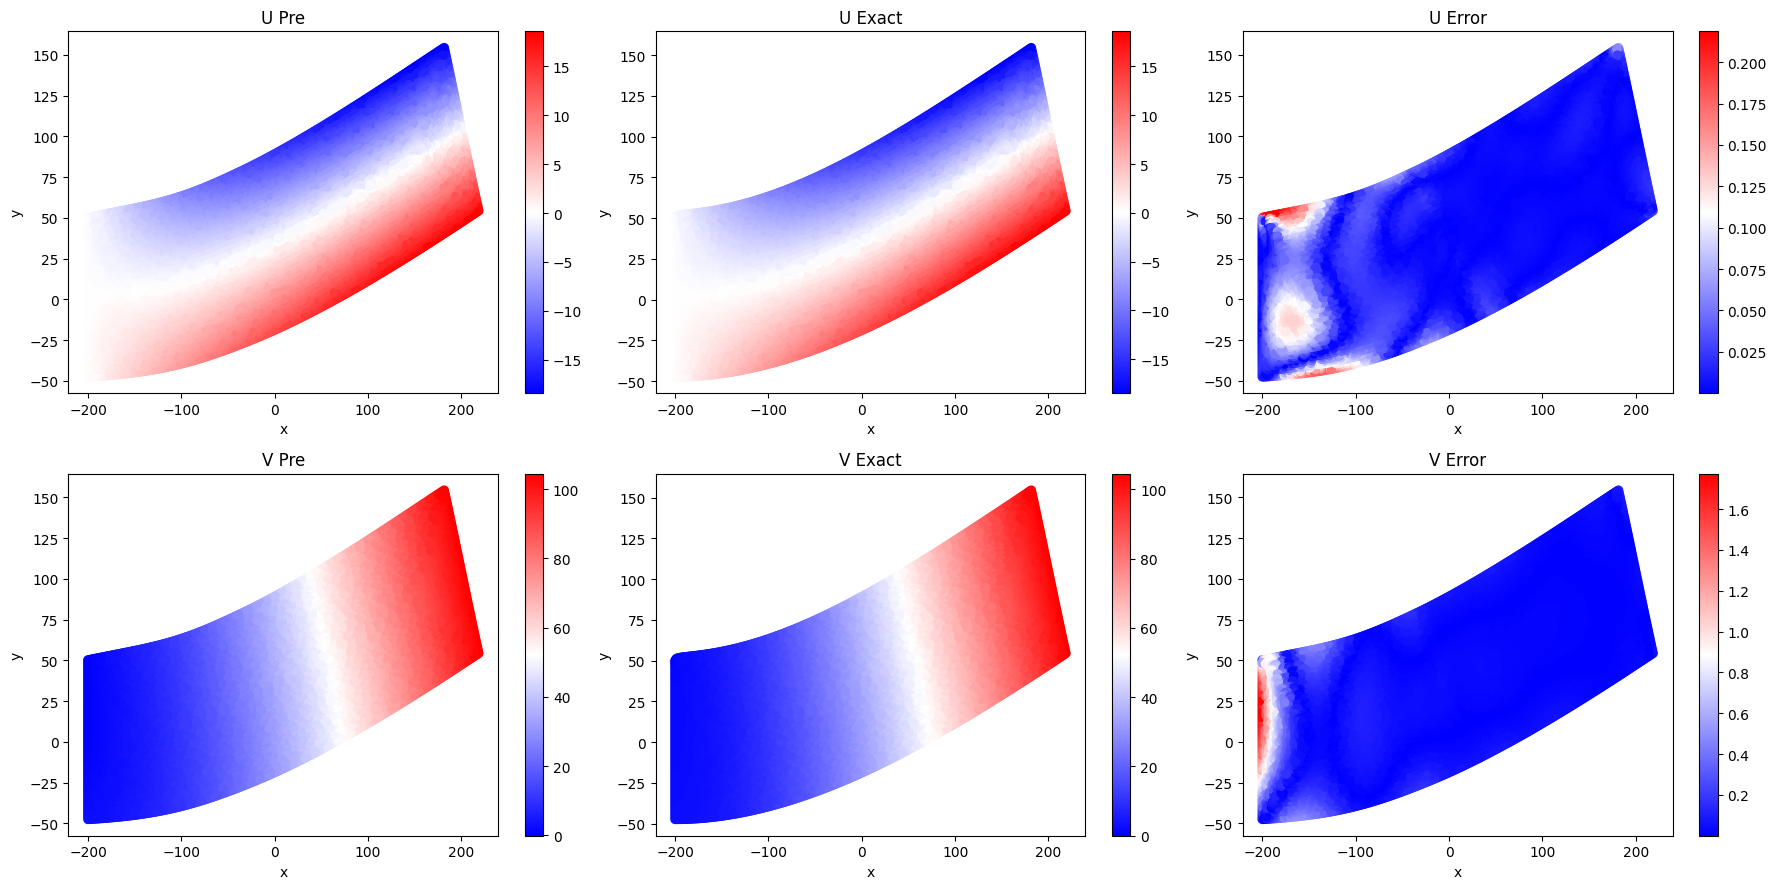

In [5]:
PINNs_model.plot_loss()
PINNs_model.plot_result(0)
PINNs_model.plot_result(1)
PINNs_model.plot_result(2)
PINNs_model.plot_result(3)
PINNs_model.plot_result(4)
PINNs_model.plot_result(5)

In [6]:
# PINNs_model.plot_result(6)
# PINNs_model.plot_result(7)
# PINNs_model.plot_result(8)
# PINNs_model.plot_result(9)
# PINNs_model.plot_result(10)
# PINNs_model.plot_result(11)
# PINNs_model.plot_result(12)
# PINNs_model.plot_result(13)
# PINNs_model.plot_result(14)
# PINNs_model.plot_result(15)
# PINNs_model.plot_result(16)
# PINNs_model.plot_result(17)
# PINNs_model.plot_result(18)